In [1]:
!pip install -q efficientnet
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=ad38ee9599e106bb6fec49b35e312f7d32adcddf586198562c3998028c870bfd
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [2]:
import skimage.io as sk

import math, re, os

import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt 
from kaggle_datasets import KaggleDatasets 
import torch 

import torch.nn as nn 

import torchvision 

from sklearn import metrics 
from sklearn.model_selection import train_test_split 
import cv2 
import matplotlib 
import matplotlib.pyplot as plt 

%matplotlib inline

## Load label and paths

In [3]:
def append_path(pre):
    
    return np.vectorize(lambda file: os.path.join("/kaggle/input/alaska2-image-steganalysis/", pre, file))

In [4]:
sub = pd.read_csv('/kaggle/input/alaska2-image-steganalysis/sample_submission.csv')

train_filenames = os.listdir("/kaggle/input/alaska2-image-steganalysis/Cover/")
train_filenames.sort(key=lambda x:x.split(".")[0])
train_filenames = np.array(train_filenames)
train_filenames 

array(['00001.jpg', '00002.jpg', '00003.jpg', ..., '80003.jpg',
       '80004.jpg', '80005.jpg'], dtype='<U9')

In [5]:
np.random.seed(1) 

## Create two variables to identify steganographic data and normal data
positives = train_filenames.copy() 
negatives = train_filenames.copy()

## Shuffle the order of data
np.random.shuffle(positives)
np.random.shuffle(negatives)

## Get the corresponding data
jmipod = append_path('JMiPOD')(positives[:5000])
juniward = append_path('JUNIWARD')(positives[10000:15000])
uerd = append_path('UERD')(positives[20000:25000])

pos_paths = np.concatenate([jmipod, juniward, uerd])


In [6]:
negatives[:10]

array(['26132.jpg', '34895.jpg', '40856.jpg', '78033.jpg', '47906.jpg',
       '31475.jpg', '03124.jpg', '51040.jpg', '54300.jpg', '31238.jpg'],
      dtype='<U9')

In [7]:
jmipod[:5]

array(['/kaggle/input/alaska2-image-steganalysis/JMiPOD/12368.jpg',
       '/kaggle/input/alaska2-image-steganalysis/JMiPOD/55496.jpg',
       '/kaggle/input/alaska2-image-steganalysis/JMiPOD/36984.jpg',
       '/kaggle/input/alaska2-image-steganalysis/JMiPOD/23623.jpg',
       '/kaggle/input/alaska2-image-steganalysis/JMiPOD/24560.jpg'],
      dtype='<U57')

In [8]:
test_paths = append_path('Test')(sub.Id.values)
neg_paths = append_path('Cover')(np.random.choice(negatives,5000))
# neg_paths = append_path('Cover')(negatives[:500])

## Splice the path of the steganographic image and the normal image
train_paths = np.concatenate([pos_paths, neg_paths])

## Set the steganographic image sample label to 1 and the normal image sample label to 0 respectively.
train_labels = np.array([1] * len(pos_paths) + [0] * len(neg_paths))

## Split training data and validation data
train_paths, valid_paths, train_labels, valid_labels = train_test_split(train_paths, train_labels, test_size=0.2)

# train_paths

In [9]:
train_paths[:10]

array(['/kaggle/input/alaska2-image-steganalysis/JMiPOD/29986.jpg',
       '/kaggle/input/alaska2-image-steganalysis/Cover/58146.jpg',
       '/kaggle/input/alaska2-image-steganalysis/Cover/01948.jpg',
       '/kaggle/input/alaska2-image-steganalysis/Cover/28158.jpg',
       '/kaggle/input/alaska2-image-steganalysis/UERD/76121.jpg',
       '/kaggle/input/alaska2-image-steganalysis/Cover/78355.jpg',
       '/kaggle/input/alaska2-image-steganalysis/Cover/09189.jpg',
       '/kaggle/input/alaska2-image-steganalysis/UERD/25339.jpg',
       '/kaggle/input/alaska2-image-steganalysis/JMiPOD/38442.jpg',
       '/kaggle/input/alaska2-image-steganalysis/UERD/29358.jpg'],
      dtype='<U59')

## Create Dataset objects


In [10]:
import torchvision.transforms as transforms
from PIL import Image

def decode_image(filename, label=None, image_size=(512, 512)):
        
        image = Image.open(filename).convert("RGB")

        
        image = transforms.Resize(image_size)(image)

        
        image = transforms.ToTensor()(image)
#         image = image.float() / 255.0

        
        if label is None:
            return image
        else:
            return image, label


def data_augment(image, label=None):
    
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),  
        transforms.RandomVerticalFlip()      
    ])
    
    image = transform(image)
    
    if label is None:
        return image
    else:
        return image, label


In [11]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image


# Configuration
EPOCHS = 10
BATCH_SIZE = 32   #16,8(Repeat)

# CustomDataset，PyTorch Dataset 
class CustomDataset(Dataset):
    def __init__(self, paths, labels=None, image_size=(512, 512), transform=None):
        self.paths = paths
        self.labels = labels
        self.image_size = image_size
        self.transform = transform
    
    # train_loader,__getitem__ 
    def __getitem__(self, index):
        path = self.paths[index]
        label = self.labels[index] if self.labels is not None else None
        
        
        image = decode_image(path)
        image = Image.open(path).convert("RGB")  
        image = data_augment(image)
        
        
        if self.transform is not None:
            image = self.transform(image)
        
        
        if label is None:
            return image
        else:
            return image, label
    
    
    def __len__(self):
        return len(self.paths)


transform = transforms.Compose([
    transforms.ToTensor()
])

'''
'''


train_dataset = CustomDataset(train_paths, train_labels, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


valid_dataset = CustomDataset(valid_paths, valid_labels, transform=transform)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)

test_dataset = CustomDataset(test_paths, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


In [12]:

dataset_size = len(train_dataset)
print("Train dataset size:", dataset_size)


batch_count = len(train_loader)
print("Train loader size (batch count):", batch_count)

Train dataset size: 16000
Train loader size (batch count): 500


## Modelling

### Load Pre Tranin Model 

Steganalysis EDA  [EfficientNet](https://arxiv.org/pdf/1905.11946.pdf)


**EfficientNet：** 

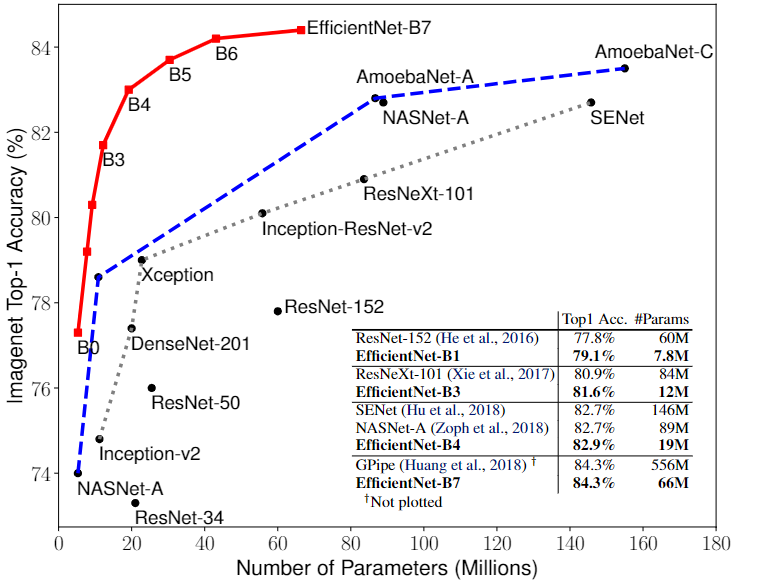

In [ ]:
'''
import torch.nn as nn
from efficientnet_pytorch import EfficientNet

# Load pre-trained EfficientNet-B3 model
model = EfficientNet.from_pretrained('efficientnet-b3')

# Replace the last layer with a linear layer, output dimension is 1
model._fc = nn.Linear(model._fc.in_features, 1)

# Freeze parameters of the blocks
for param in model._blocks.parameters():
    param.requires_grad_(False)

# Print the model structure
print(model)
'''

In [13]:
import torch
import torch.nn as nn
from torchvision import models


model = models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)


for param in model.parameters():
    param.requires_grad_(False)
model.fc.weight.requires_grad_(True)
model.fc.bias.requires_grad_(True)

print(model)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 140MB/s] 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
#for name, param in model.named_parameters():
 #   if param.requires_grad:
#        print(name, "is trainable")
 #   else:
  #      print(name, "is frozen")

### Start training

In [ ]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

# # Define the device, using GPU if available, otherwise use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the number of steps per epoch
STEPS_PER_EPOCH = len(train_dataset) // BATCH_SIZE

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  #  Binary cross-entropy loss function
optimizer = optim.Adam(model.parameters())  # Adam optimizer
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode ='max', factor=0.5, patience=2, 
                                                    threshold = 0.001, 
                                                    min_lr = 1e-5, threshold_mode = 'abs')
# Initialize lists to store training and validation losses and accuracies
train_loss_list = []
valid_loss_list = []
accuracy_list = []
val_accuracy_list = []

# Start the training loop
for epoch in range(EPOCHS):
    model = model.to(device)  # Move the model to the specified device
    model.train()  # Set the model to training mode
    
    train_loss = 0
    train_correct = 0
    train_samples = 0

    # Iterate over the training data loader
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device).float()  # Convert labels to float type
        labels = labels.unsqueeze(1)  # Add a dimension to match the model output

        optimizer.zero_grad()        
        outputs = model(images)      
        loss = criterion(outputs, labels) 
        loss.backward()             
        optimizer.step()            

        train_loss += loss.item()  
        predicted = torch.round(torch.sigmoid(outputs))
        train_correct += (predicted == labels).sum().item() 
        train_samples += labels.size(0)                     
        accuracy = train_correct / train_samples            

        train_loss_list.append(train_loss / (i+1))          
        accuracy_list.append(accuracy)                      

    # Validate on the validation data loader
    model.eval()  
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(valid_loader):
            images = images.to(device)
            labels = labels.to(device).float()  
            labels = labels.unsqueeze(1)  

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            predicted = torch.round(torch.sigmoid(outputs))
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            
            valid_loss = total_loss / (i+1)

            accuracy = total_correct / total_samples
        lr_scheduler.step(valid_loss)
        valid_loss_list.append(valid_loss)
        val_accuracy_list.append(accuracy)
    
    # Print the validation loss and accuracy for the current epoch
    print(f"Epoch [{epoch+1}/{EPOCHS}], Validation Loss: {valid_loss:.4f}, Accuracy: {accuracy:.4f}")

Epoch [1/10], Validation Loss: 0.5541, Accuracy: 0.7642
Epoch [2/10], Validation Loss: 0.5523, Accuracy: 0.7642
Epoch [3/10], Validation Loss: 0.5695, Accuracy: 0.7642
Epoch [4/10], Validation Loss: 0.5779, Accuracy: 0.7600
Epoch [5/10], Validation Loss: 0.5534, Accuracy: 0.7635
Epoch [6/10], Validation Loss: 0.5552, Accuracy: 0.7638
Epoch [7/10], Validation Loss: 0.5574, Accuracy: 0.7632
Epoch [8/10], Validation Loss: 0.5523, Accuracy: 0.7632
Epoch [9/10], Validation Loss: 0.5590, Accuracy: 0.7625
Epoch [10/10], Validation Loss: 0.5525, Accuracy: 0.7642


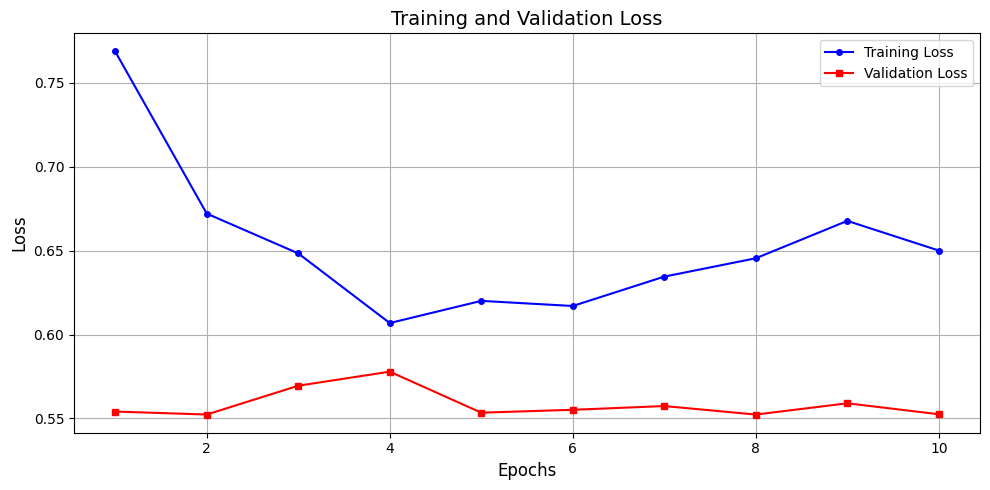

In [15]:
import matplotlib.pyplot as plt

# Plot both training and validation loss on the same graph
plt.figure(figsize=(10, 5))

# Plot training loss
plt.plot(range(1, len(train_loss_list) // STEPS_PER_EPOCH + 1), train_loss_list[:len(train_loss_list) // STEPS_PER_EPOCH], color='blue', linestyle='-', marker='o', markersize=4, label='Training Loss')

# Plot validation loss
plt.plot(range(1, len(valid_loss_list) + 1), valid_loss_list, color='red', linestyle='-', marker='s', markersize=4, label='Validation Loss')

plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14)
plt.legend()
plt.grid(True)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()


ValueError: x and y must have same first dimension, but have shapes (10,) and (5000,)

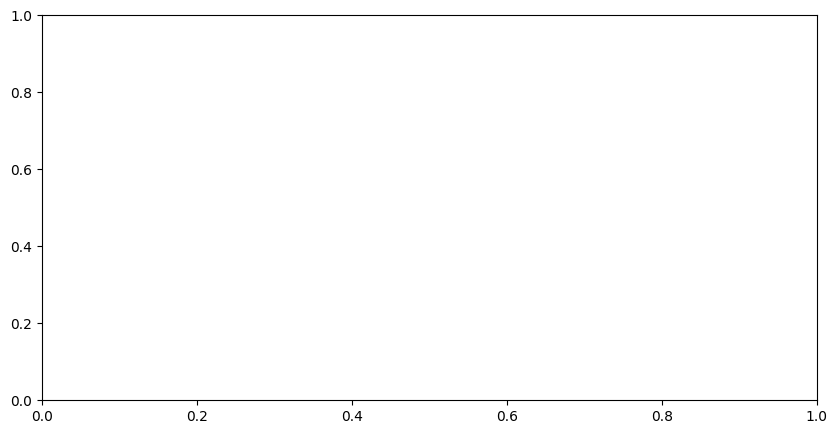

In [17]:
import matplotlib.pyplot as plt

# Plot both training and validation loss on the same graph
plt.figure(figsize=(10, 5))

# Plot training loss
plt.plot(range(1, EPOCHS + 1), train_loss_list, color='blue', linestyle='-', marker='o', markersize=4, label='Training Loss')

# Plot validation loss
plt.plot(range(1, EPOCHS + 1), valid_loss_list, color='red', linestyle='-', marker='s', markersize=4, label='Validation Loss')

plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14)
plt.legend()
plt.grid(True)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()


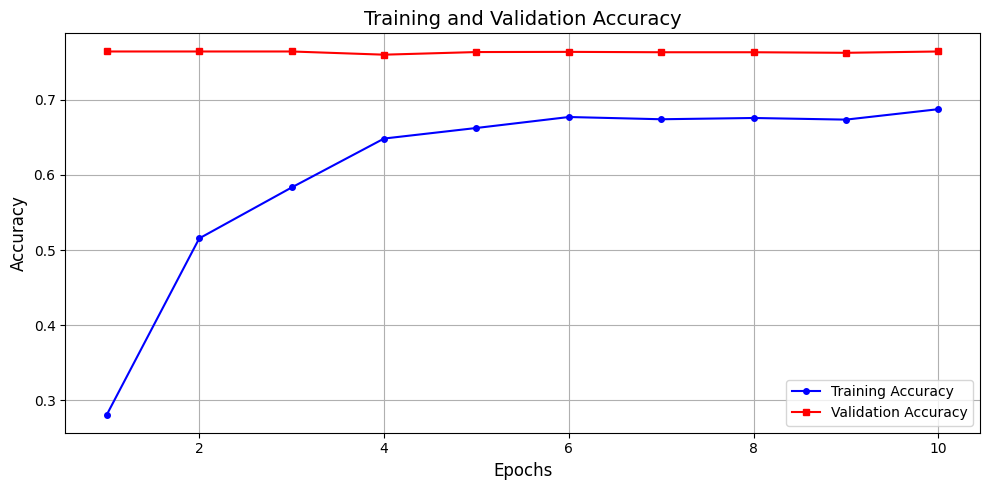

In [18]:
import matplotlib.pyplot as plt



# Plot both training and validation accuracy on the same graph
plt.figure(figsize=(10, 5))

# Plot training accuracy
plt.plot(range(1, len(accuracy_list) // STEPS_PER_EPOCH + 1), accuracy_list[:len(accuracy_list) // STEPS_PER_EPOCH], color='blue', linestyle='-', marker='o', markersize=4, label='Training Accuracy')

# Plot validation accuracy
plt.plot(range(1, len(val_accuracy_list) + 1), val_accuracy_list, color='red', linestyle='-', marker='s', markersize=4, label='Validation Accuracy')

plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Training and Validation Accuracy', fontsize=14)
plt.legend()
plt.grid(True)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
# valid_loss_list

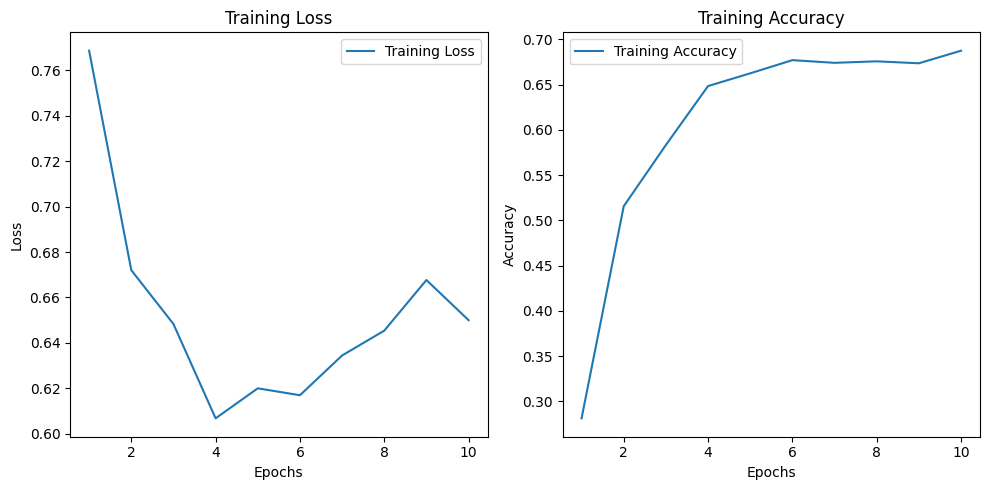

In [19]:
import matplotlib.pyplot as plt

# Plot training loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss_list) // STEPS_PER_EPOCH + 1), train_loss_list[:len(train_loss_list) // STEPS_PER_EPOCH], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(accuracy_list) // STEPS_PER_EPOCH + 1), accuracy_list[:len(accuracy_list) // STEPS_PER_EPOCH], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


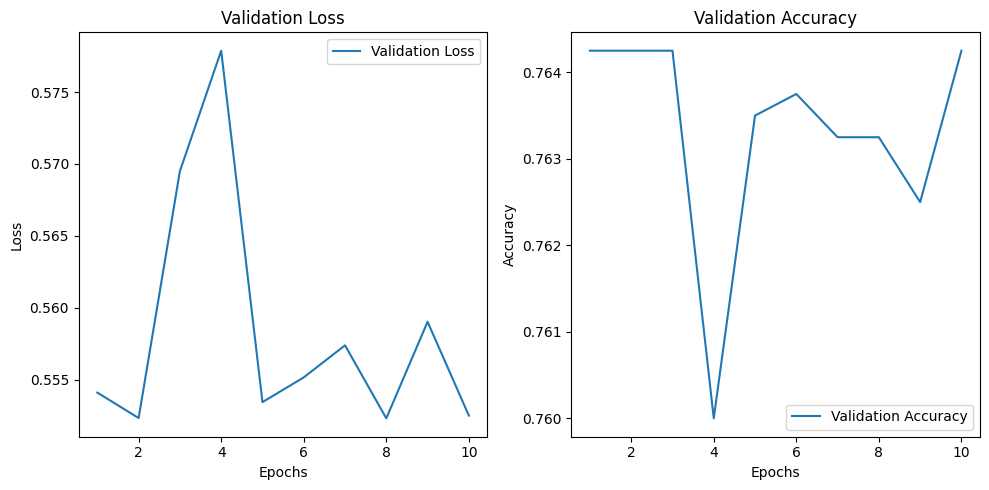

In [20]:
import matplotlib.pyplot as plt



# Plot validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(valid_loss_list) + 1), valid_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracy_list) + 1), val_accuracy_list, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


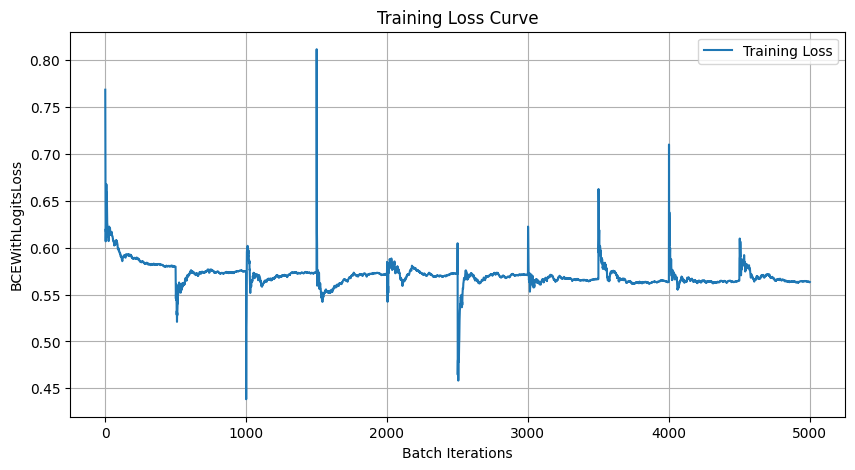

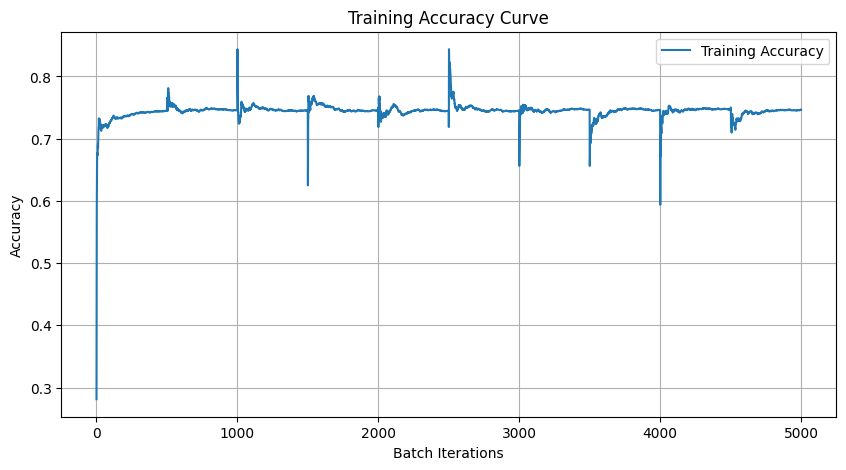

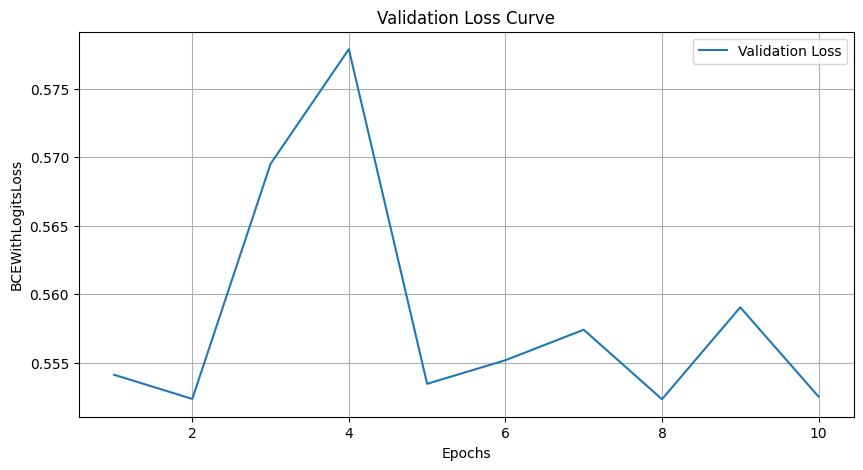

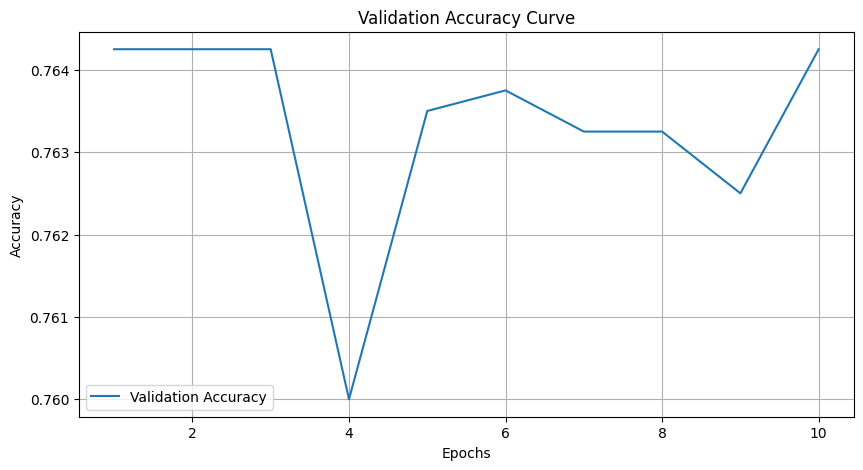

In [21]:
import matplotlib.pyplot as plt

# Assuming you have already collected train_loss_list, accuracy_list, valid_loss_list, and val_accuracy_list.

# Plotting the training loss curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss_list) + 1), train_loss_list, label='Training Loss')
plt.xlabel('Batch Iterations')
plt.ylabel('BCEWithLogitsLoss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the training accuracy curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(accuracy_list) + 1), accuracy_list, label='Training Accuracy')
plt.xlabel('Batch Iterations')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Curve')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the validation loss curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(valid_loss_list) + 1), valid_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('BCEWithLogitsLoss')
plt.title('Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the validation accuracy curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(val_accuracy_list) + 1), val_accuracy_list, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Curve')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# model.save("model3.h5")

In [23]:
import torch
torch.save(model.state_dict(),"resnet18.pth")